In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product

ModuleNotFoundError: No module named 'pmdarima'

In [2]:
df = pd.read_csv('power_consumption.csv', parse_dates=['Date'])
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2010-01-11,00:00:00,1.368,0.080,246.50,5.6,0.0,0.0,1.0
1,2010-01-11,00:01:00,1.368,0.080,246.55,5.6,0.0,0.0,1.0
2,2010-01-11,00:02:00,1.366,0.080,246.46,5.6,0.0,0.0,1.0
3,2010-01-11,00:03:00,1.312,0.000,246.20,5.4,0.0,0.0,0.0
4,2010-01-11,00:04:00,1.268,0.062,246.10,5.2,0.0,0.0,1.0


In [3]:
df = df.assign(Active_energy = lambda x: (x['Global_active_power']*1000/60-x['Sub_metering_1']-x['Sub_metering_2']-x['Sub_metering_3']))
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Active_energy
0,2010-01-11,00:00:00,1.368,0.080,246.50,5.6,0.0,0.0,1.0,21.800000
1,2010-01-11,00:01:00,1.368,0.080,246.55,5.6,0.0,0.0,1.0,21.800000
2,2010-01-11,00:02:00,1.366,0.080,246.46,5.6,0.0,0.0,1.0,21.766667
3,2010-01-11,00:03:00,1.312,0.000,246.20,5.4,0.0,0.0,0.0,21.866667
4,2010-01-11,00:04:00,1.268,0.062,246.10,5.2,0.0,0.0,1.0,20.133333


(array([6.198e+03, 1.329e+03, 1.482e+03, 8.330e+02, 1.610e+02, 5.000e+01,
        1.900e+01, 3.000e+00, 0.000e+00, 5.000e+00]),
 array([ 1.23333333,  8.41      , 15.58666667, 22.76333333, 29.94      ,
        37.11666667, 44.29333333, 51.47      , 58.64666667, 65.82333333,
        73.        ]),
 <BarContainer object of 10 artists>)

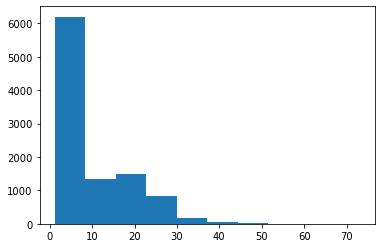

In [4]:
plt.hist(df['Active_energy'])

Text(0.5, 0, 'Time in Minute')

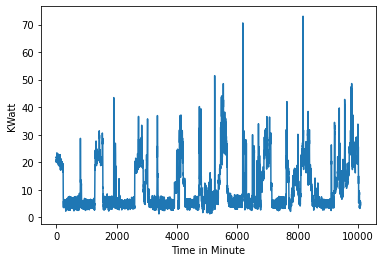

In [5]:
plt.plot(df['Active_energy'])
plt.ylabel('KWatt')
plt.xlabel('Time in Minute')

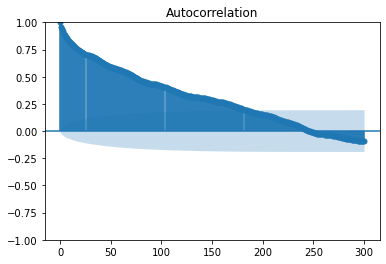

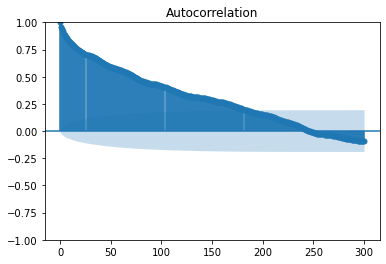

In [6]:
plot_acf(df.Active_energy, lags = 300)

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


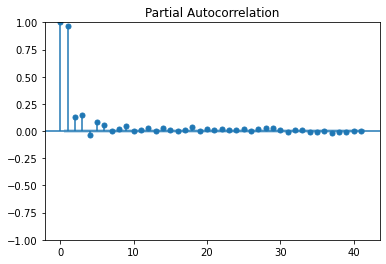

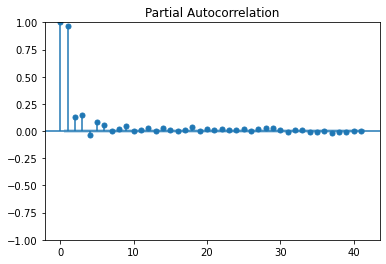

In [7]:
plot_pacf(df['Active_energy'])

In [8]:
def stationarity(df, window, n):
  # Dickey–Fuller test:
  result = adfuller(df['Active_energy'])
  print('ADF Statistic: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
  if result[1] <= 0.05:
      print("Result: strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
  else:
      print("Result: weak evidence against null hypothesis, indicating it is non-stationery")    
stationarity(df,10,len(df.Active_energy))

ADF Statistic: -6.005782226595799
p-value: 1.6168352879878186e-07
Critical Values:
	1%: -3.431000778118482
	5%: -2.861827605377372
	10%: -2.566923087202734
Result: strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


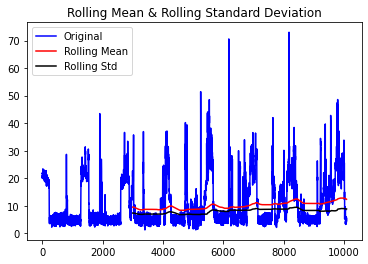

In [9]:
rolling_mean = df['Active_energy'].rolling(window = 3000).mean()
rolling_std = df['Active_energy'].rolling(window = 3000).std()
plt.plot(df['Active_energy'], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

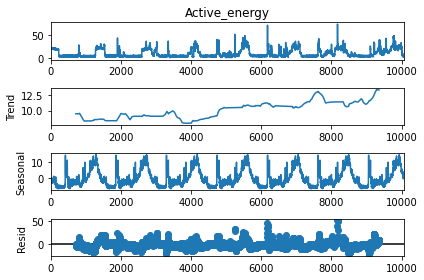

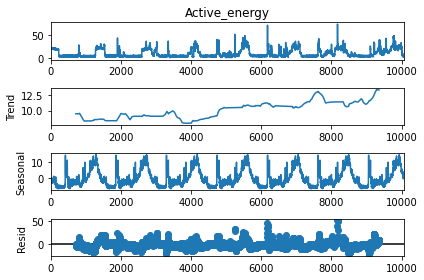

In [10]:
seasonal_decompose(df['Active_energy'], model='additive', period=1440).plot() #1440 = menit perhari

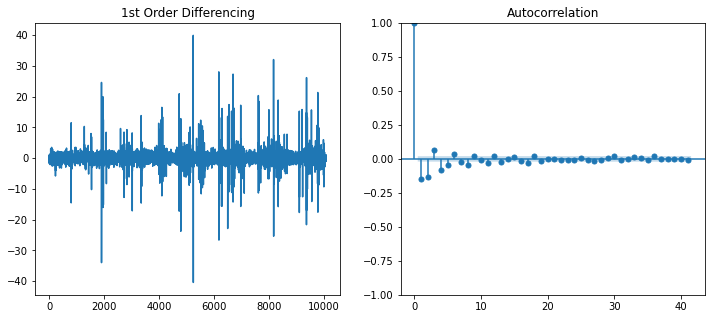

In [11]:
f = plt.figure(figsize = (12,5))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.Active_energy.diff())

ax2 = f.add_subplot(122)
plot_acf(df.Active_energy.diff().dropna(), ax=ax2)
plt.show()

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


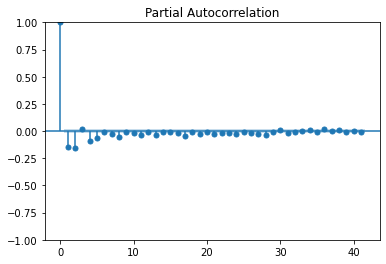

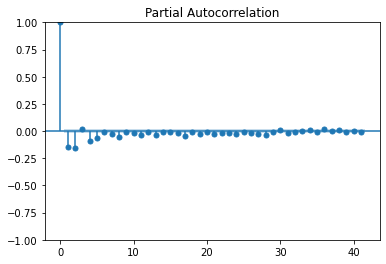

In [12]:
plot_pacf(df.Active_energy.diff().dropna())

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


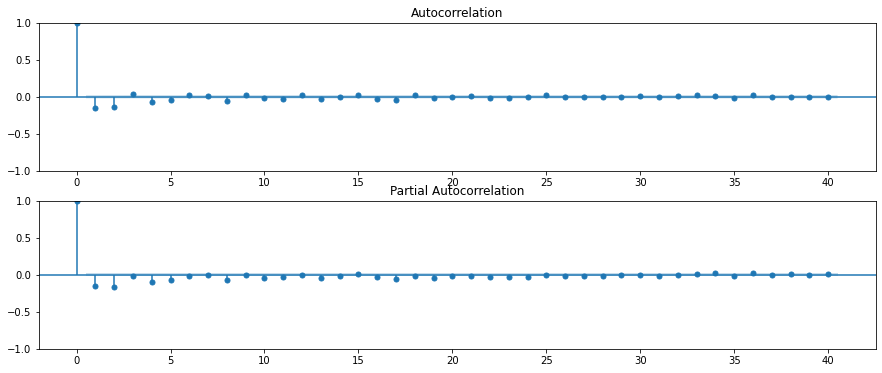

In [13]:
df['Seasonal_First_Difference'] = df['Active_energy'].diff() - df['Active_energy'].diff().shift(1440)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal_First_Difference'].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal_First_Difference'].dropna(), ax=ax2)

In [24]:
train =  df[:len(df)-2016]
test = df[len(df)-2016:]
len(df) == len(train) + len(test)

start = len(train)
end = len(train)+len(test)-1

exog_train = train.iloc[:,1:]['Active_energy'] 
exog_forecast = test.iloc[:,1:]['Active_energy']

In [25]:
model = SARIMAX(train['Active_energy'], exog=exog_train,order=(2,0,0),seasonal_order=(2,0,0,24)).fit()
print(model.summary())

C:\Users\Hp\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                      Active_energy   No. Observations:                 8064
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood               85500.070
Date:                            Wed, 09 Nov 2022   AIC                        -170988.140
Time:                                    10:49:47   BIC                        -170946.169
Sample:                                         0   HQIC                       -170973.779
                                           - 8064                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Active_energy     1.0000   1.75e-08   5.71e+07      0.000       1.000       1.000
ar.L1             0.6340  

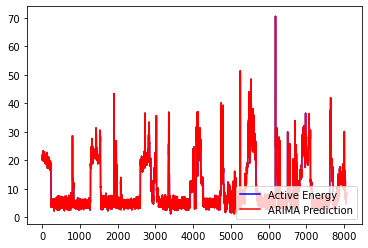

In [26]:
plt.plot(train['Active_energy'], color='blue', label = 'Active Energy')
plt.plot(model.fittedvalues, color='red', label = 'ARIMA Prediction')
plt.legend(loc='lower right')

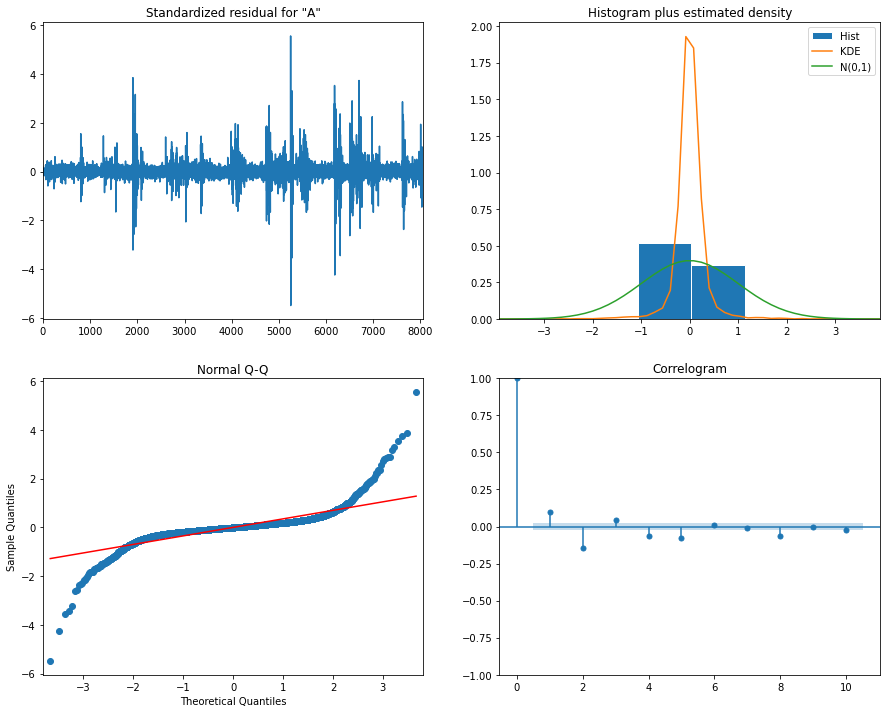

In [27]:
model.plot_diagnostics(figsize=(15,12));

In [29]:
y_pred = pd.Series(model.predict(start=start, end=end, exog=exog_forecast), index=test[:2016].index)
y_true = test['Active_energy']
print(np.array(y_pred).astype(np.uint8))
print(np.array(y_true))

mape = np.mean(np.abs(y_pred-y_true)/np.abs(y_true))
mae = np.mean(np.abs(y_pred - y_true))
mpe = np.mean((y_pred - y_true)/y_true)
rmse = np.mean((y_pred - y_true)**2)**.5
corr = np.corrcoef(y_pred, y_true)[0,1]

mins = np.amin(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
maxs = np.amax(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
minmax = 1 - np.mean(mins/maxs)

import pprint
pprint.pprint({'mape': mape, 'mae': mae,
               'mpe': mpe, 'rmse': rmse,
               'corr': corr, 'minmax': minmax})

[10  8  7 ...  4  5  4]
[10.16666667  8.6         7.93333333 ...  4.6         5.6
  4.56666667]


C:\Users\Hp\AppData\Local\Temp\ipykernel_1904\720520132.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)
C:\Users\Hp\AppData\Local\Temp\ipykernel_1904\720520132.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([y_pred[:,None], y_true[:,None]]), axis=1)


{'corr': 0.999999999999988,
 'mae': 1.6409976711106692e-05,
 'mape': 1.148695757671985e-06,
 'minmax': 1.1486957565143285e-06,
 'mpe': -1.14402417620336e-06,
 'rmse': 1.990941066978395e-05}


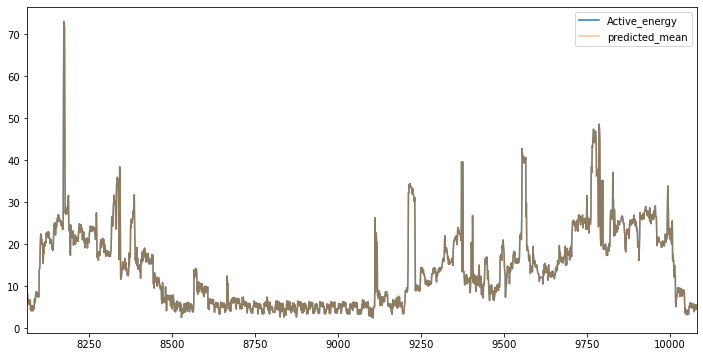

In [42]:
ax = test['Active_energy'].plot(legend=True,figsize=(12,6))
y_pred.plot(legend=True, alpha=0.5)
ax.autoscale(axis='x',tight=True)

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 3, 1)
d = 1
q = range(0, 3, 1)
P = range(0, 3, 1)
D = 1
Q = range(0, 3, 1)
s = 28
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

In [ ]:
#result_df = optimize_SARIMA(parameters_list, 1, 1, 28, train['Active_energy'])
#result_df

In [ ]:
def walk_forward(training_set, validation_set, params):
    history = [x for x in training_set.values]
    prediction = list()
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params
    # Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = SARIMAX(history, order=pdq, seasonal_order=PDQS)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end = len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
    print(result.summary())
    return prediction